In [1]:
import dgl.nn as dglnn
from dgl import from_networkx
import torch.nn as nn
import torch as th
import torch.nn.functional as F
import dgl.function as fn
import networkx as nx
import pandas as pd
import socket
import struct
import random
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

Using backend: pytorch
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
data = pd.read_csv('NF-BoT-IoT.csv')

In [3]:
data

,IPV4_SRC_ADDR,L4_SRC_PORT,IPV4_DST_ADDR,L4_DST_PORT,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,192.168.100.6,52670,192.168.100.1,53,17,5.212,71,126,1,1,0,4294966,0,Benign
1,192.168.100.6,49160,192.168.100.149,4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft
2,192.168.100.46,3456,192.168.100.5,80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,192.168.100.3,80,192.168.100.55,8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,192.168.100.46,80,192.168.100.5,80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
600095,192.168.100.46,80,192.168.100.5,80,6,7.000,2330065,0,2523,0,0,4263037,0,Benign
600096,192.168.100.5,0,192.168.100.3,0,6,0.000,1054423,0,1513,0,0,4263062,0,Benign
600097,192.168.100.7,365,192.168.100.3,565,17,0.000,62422,0,1357,0,0,4263062,0,Benign
600098,192.168.100.3,50850,13.54.166.67,8883,6,222.178,11300,1664,32,32,24,4264935,0,Benign


In [4]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(lambda x: socket.inet_ntoa(struct.pack('>I', random.randint(0xac100001, 0xac1f0001))))

In [5]:
data['IPV4_SRC_ADDR'] = data.IPV4_SRC_ADDR.apply(str)
data['L4_SRC_PORT'] = data.L4_SRC_PORT.apply(str)
data['IPV4_DST_ADDR'] = data.IPV4_DST_ADDR.apply(str)
data['L4_DST_PORT'] = data.L4_DST_PORT.apply(str)

In [6]:
data['IPV4_SRC_ADDR'] = data['IPV4_SRC_ADDR'] + ':' + data['L4_SRC_PORT']
data['IPV4_DST_ADDR'] = data['IPV4_DST_ADDR'] + ':' + data['L4_DST_PORT']

In [7]:
data.drop(columns=['L4_SRC_PORT','L4_DST_PORT'],inplace=True)

In [8]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,Label,Attack
0,172.16.136.22:52670,192.168.100.1:53,17,5.212,71,126,1,1,0,4294966,0,Benign
1,172.19.122.45:49160,192.168.100.149:4444,6,0.000,217753000,199100,4521,4049,24,4176249,1,Theft
2,172.19.178.98:3456,192.168.100.5:80,17,0.000,8508021,8918372,9086,9086,0,4175916,0,Benign
3,172.27.217.67:80,192.168.100.55:8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0,Benign
4,172.17.161.166:80,192.168.100.5:80,6,7.000,8374706,0,9086,0,0,4175916,0,Benign
...,...,...,...,...,...,...,...,...,...,...,...,...
600095,172.16.170.111:80,192.168.100.5:80,6,7.000,2330065,0,2523,0,0,4263037,0,Benign
600096,172.16.99.96:0,192.168.100.3:0,6,0.000,1054423,0,1513,0,0,4263062,0,Benign
600097,172.19.110.55:365,192.168.100.3:565,17,0.000,62422,0,1357,0,0,4263062,0,Benign
600098,172.20.134.141:50850,13.54.166.67:8883,6,222.178,11300,1664,32,32,24,4264935,0,Benign


In [9]:
data.drop(columns=['Attack'],inplace = True)

In [10]:
data.rename(columns={"Label": "label"},inplace = True)

In [11]:
label = data.label

In [12]:
data.drop(columns=['label'],inplace = True)

In [13]:
scaler = StandardScaler()

In [14]:
data =  pd.concat([data, label], axis=1)

In [15]:
data

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
0,172.16.136.22:52670,192.168.100.1:53,17,5.212,71,126,1,1,0,4294966,0
1,172.19.122.45:49160,192.168.100.149:4444,6,0.000,217753000,199100,4521,4049,24,4176249,1
2,172.19.178.98:3456,192.168.100.5:80,17,0.000,8508021,8918372,9086,9086,0,4175916,0
3,172.27.217.67:80,192.168.100.55:8080,6,7.000,8442138,9013406,9086,9086,0,4175916,0
4,172.17.161.166:80,192.168.100.5:80,6,7.000,8374706,0,9086,0,0,4175916,0
...,...,...,...,...,...,...,...,...,...,...,...
600095,172.16.170.111:80,192.168.100.5:80,6,7.000,2330065,0,2523,0,0,4263037,0
600096,172.16.99.96:0,192.168.100.3:0,6,0.000,1054423,0,1513,0,0,4263062,0
600097,172.19.110.55:365,192.168.100.3:565,17,0.000,62422,0,1357,0,0,4263062,0
600098,172.20.134.141:50850,13.54.166.67:8883,6,222.178,11300,1664,32,32,24,4264935,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(
     data, label, test_size=0.3, random_state=123,stratify= label)

In [17]:
encoder = ce.TargetEncoder(cols=['TCP_FLAGS','L7_PROTO','PROTOCOL'])
encoder.fit(X_train, y_train)
X_train = encoder.transform(X_train)

/usr/local/lib/python3.6/dist-packages/category_encoders/utils.py:21: FutureWarning: is_categorical is deprecated and will be removed in a future version.  Use is_categorical_dtype instead
  elif pd.api.types.is_categorical(cols):


In [18]:
cols_to_norm = list(set(list(X_train.iloc[:, 2:].columns ))  - set(list(['label'])) )
X_train[cols_to_norm] = scaler.fit_transform(X_train[cols_to_norm])

In [19]:
X_train

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
398456,172.16.54.186:47768,192.168.100.7:2043,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
189579,172.18.59.187:41228,192.168.100.5:1011,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
463036,172.25.238.190:36130,192.168.100.3:5801,0.242607,0.041512,-0.017276,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
324954,172.20.41.245:45196,192.168.100.7:1277,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
185030,172.25.9.193:48136,192.168.100.3:2190,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
...,...,...,...,...,...,...,...,...,...,...,...
169412,172.17.114.147:41020,192.168.100.5:6666,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496714,1
522250,172.22.53.208:3780,192.168.100.3:1,0.242607,-3.014581,-0.017313,-0.008442,-0.045637,-0.027054,-0.876614,0.496716,1
218225,172.16.208.148:45576,192.168.100.3:7741,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
1072,172.29.232.100:42920,192.168.100.3:80,0.242607,0.254635,-0.016184,-0.007523,-0.029495,-0.009069,-0.096099,0.489584,1


In [20]:
X_train['h'] = X_train[ cols_to_norm ].values.tolist()

In [21]:
G = nx.from_pandas_edgelist(X_train, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())

In [22]:
G = G.to_directed()


In [23]:
G = from_networkx(G,edge_attrs=['h','label'] )


In [24]:
# Eq1
G.ndata['h'] = th.ones(G.num_nodes(), G.edata['h'].shape[1])

In [25]:
G.edata['train_mask'] = th.ones(len(G.edata['h']), dtype=th.bool)


In [26]:
G.edata['train_mask'] 

tensor([True, True, True,  ..., True, True, True])

In [27]:
def compute_accuracy(pred, labels):
    return (pred.argmax(1) == labels).float().mean().item()

In [28]:
class SAGELayer(nn.Module):
    def __init__(self, ndim_in, edims, ndim_out, activation):
        super(SAGELayer, self).__init__()
        ### force to outut fix dimensions
        self.W_msg = nn.Linear(ndim_in + edims, ndim_out)
        ### apply weight
        self.W_apply = nn.Linear(ndim_in + ndim_out, ndim_out)
        self.activation = activation

    def message_func(self, edges):
        return {'m': self.W_msg(th.cat([edges.src['h'], edges.data['h']], 2))}

    def forward(self, g_dgl, nfeats, efeats):
        with g_dgl.local_scope():
            g = g_dgl
            g.ndata['h'] = nfeats
            g.edata['h'] = efeats
            # Eq4
            g.update_all(self.message_func, fn.mean('m', 'h_neigh'))
            # Eq5          
            g.ndata['h'] = F.relu(self.W_apply(th.cat([g.ndata['h'], g.ndata['h_neigh']], 2)))
            return g.ndata['h']


class SAGE(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super(SAGE, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(SAGELayer(ndim_in, edim, 128, activation))
        self.layers.append(SAGELayer(128, edim, ndim_out, activation))
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, g, nfeats, efeats):
        for i, layer in enumerate(self.layers):
            if i != 0:
                nfeats = self.dropout(nfeats)
            nfeats = layer(g, nfeats, efeats)
        return nfeats.sum(1)

In [29]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(th.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [30]:
G.ndata['h'] = th.reshape(G.ndata['h'], (G.ndata['h'].shape[0], 1,G.ndata['h'].shape[1]))
G.edata['h'] = th.reshape(G.edata['h'], (G.edata['h'].shape[0], 1,G.edata['h'].shape[1]))

In [31]:
class Model(nn.Module):
    def __init__(self, ndim_in, ndim_out, edim, activation, dropout):
        super().__init__()
        self.gnn = SAGE(ndim_in, ndim_out, edim, activation, dropout)
        self.pred = MLPPredictor(ndim_out, 2)
    def forward(self, g, nfeats, efeats):
        h = self.gnn(g, nfeats, efeats)
        return self.pred(g, h)

In [32]:
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(G.edata['label'].cpu().numpy()),
                                                 G.edata['label'].cpu().numpy())

In [33]:
class_weights

array([21.65086074,  0.51181985])

In [34]:
class_weights = th.FloatTensor(class_weights).cuda()
criterion = nn.CrossEntropyLoss(weight=class_weights)

In [35]:
G = G.to('cuda:0')
G.device

device(type='cuda', index=0)

In [36]:
G.ndata['h'].device


device(type='cuda', index=0)

In [37]:
G.edata['h'].device


device(type='cuda', index=0)

In [59]:
node_features = G.ndata['h']
edge_features = G.edata['h']

edge_label = G.edata['label']
train_mask = G.edata['train_mask']

model = Model(G.ndata['h'].shape[2], 128, G.ndata['h'].shape[2], F.relu, 0.2).cuda()
opt = th.optim.Adam(model.parameters())

for epoch in range(1,5500):
    pred = model(G, node_features,edge_features).cuda()
    loss = criterion(pred[train_mask] ,edge_label[train_mask])
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch % 100 == 0:
      print('Training acc:', compute_accuracy(pred[train_mask], edge_label[train_mask]))


Training acc: 0.917657732963562
Training acc: 0.9214499592781067
Training acc: 0.9220617413520813
Training acc: 0.9209012389183044
Training acc: 0.9199811816215515
Training acc: 0.9219117760658264
Training acc: 0.9213380813598633
Training acc: 0.9229342341423035
Training acc: 0.9236853122711182
Training acc: 0.9310590624809265
Training acc: 0.9283750057220459
Training acc: 0.9307484030723572
Training acc: 0.9339216947555542
Training acc: 0.9336300492286682
Training acc: 0.9345822930335999
Training acc: 0.9322493672370911
Training acc: 0.9349703192710876
Training acc: 0.931145966053009
Training acc: 0.9312126040458679
Training acc: 0.9338704943656921
Training acc: 0.9308186173439026
Training acc: 0.9341264367103577
Training acc: 0.9359832406044006
Training acc: 0.9327052235603333
Training acc: 0.9318863153457642
Training acc: 0.9356821179389954
Training acc: 0.9337419867515564
Training acc: 0.9338050484657288
Training acc: 0.9354238510131836
Training acc: 0.9327445030212402
Training acc

In [39]:
X_test = encoder.transform(X_test)

In [40]:
X_test[cols_to_norm] = scaler.transform(X_test[cols_to_norm])

In [41]:
X_test

,IPV4_SRC_ADDR,IPV4_DST_ADDR,PROTOCOL,L7_PROTO,IN_BYTES,OUT_BYTES,IN_PKTS,OUT_PKTS,TCP_FLAGS,FLOW_DURATION_MILLISECONDS,label
175006,172.20.224.183:52476,192.168.100.6:3371,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
42610,172.20.88.47:42656,192.168.100.3:80,0.242607,0.254635,-0.016078,-0.007523,-0.025459,-0.009069,0.321493,0.488632,1
343626,172.24.83.27:59940,192.168.100.7:7402,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
125174,172.17.188.133:14622,192.168.100.3:12344,0.242607,0.041512,-0.017313,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
118951,172.28.20.54:53588,192.168.100.6:5002,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
...,...,...,...,...,...,...,...,...,...,...,...
190354,172.19.134.92:56591,192.168.100.5:50300,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
568549,172.16.123.10:34808,192.168.100.3:80,0.242607,0.254635,-0.015753,-0.007441,-0.021424,-0.003074,0.321493,-2.080333,1
302561,172.24.94.101:62675,192.168.100.6:211,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1
451022,172.22.196.215:37508,192.168.100.3:42510,0.242607,0.041512,-0.017305,-0.008442,-0.045637,-0.027054,0.343039,0.496716,1


In [42]:
X_test['h'] = X_test[ cols_to_norm ].values.tolist()

In [43]:
G_test = nx.from_pandas_edgelist(X_test, "IPV4_SRC_ADDR", "IPV4_DST_ADDR", ['h','label'],create_using=nx.MultiGraph())
G_test = G_test.to_directed()
G_test = from_networkx(G_test,edge_attrs=['h','label'] )
actual = G_test.edata.pop('label')
G_test.ndata['feature'] = th.ones(G_test.num_nodes(), G.ndata['h'].shape[2])

In [44]:
G_test.ndata['feature'] = th.reshape(G_test.ndata['feature'], (G_test.ndata['feature'].shape[0], 1, G_test.ndata['feature'].shape[1]))

In [45]:
G_test.edata['h'] = th.reshape(G_test.edata['h'], (G_test.edata['h'].shape[0], 1, G_test.edata['h'].shape[1]))


In [46]:
G_test = G_test.to('cuda:0')


In [60]:
import timeit
start_time = timeit.default_timer()
node_features_test = G_test.ndata['feature']
edge_features_test = G_test.edata['h']
test_pred = model(G_test, node_features_test, edge_features_test).cuda()
elapsed = timeit.default_timer() - start_time

In [61]:
print(str(elapsed) + ' seconds')


0.029059830000278453 seconds


In [62]:
test_pred = test_pred.argmax(1)


In [63]:
test_pred = th.Tensor.cpu(test_pred).detach().numpy()


In [64]:
actual = ["Normal" if i == 0 else "Attack" for i in actual]
test_pred = ["Normal" if i == 0 else "Attack" for i in test_pred]

In [65]:
from sklearn.metrics import plot_confusion_matrix


In [66]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(12, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

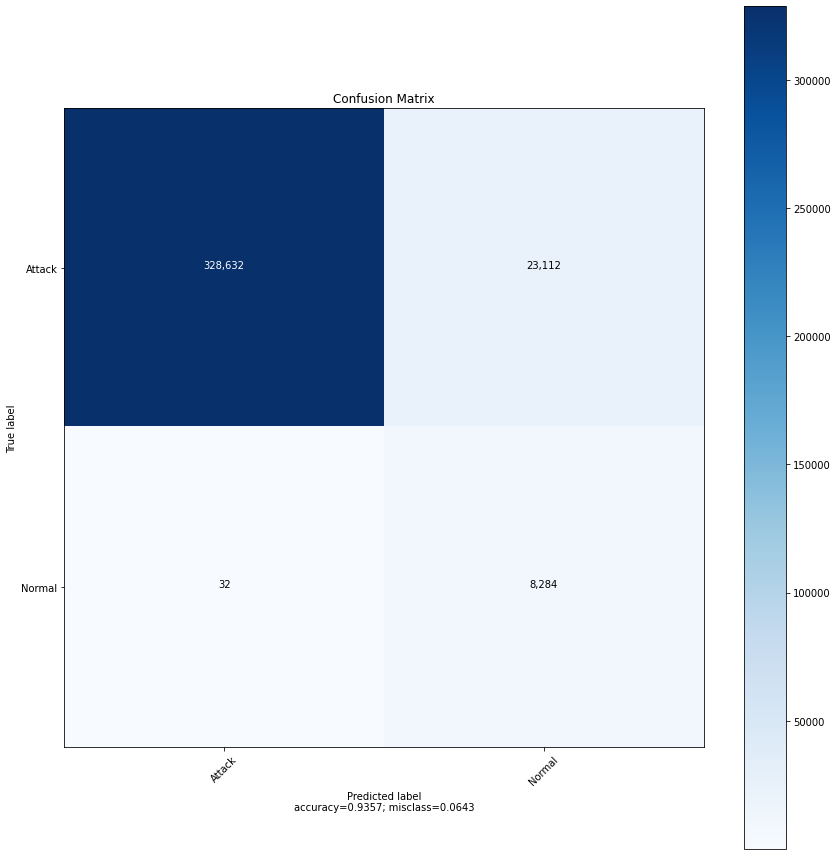

In [67]:
from sklearn.metrics import confusion_matrix

plot_confusion_matrix(cm = confusion_matrix(actual, test_pred), 
                      normalize    = False,
                      target_names = np.unique(actual),
                      title        = "Confusion Matrix")